In [1]:
import os, sys
sys.path.append("/home/alexanderalbizu")
sys.path.append("/home/alexanderalbizu/.local/bin")
os.environ["WANDB_NOTEBOOK_NAME"] = "CNN.ipynb"
#!python setup.py develop 
# !pip install wandb
# !pip install 'monai[all]'
#!pip -q install vit_pytorch
#!pip -q install linformer

In [25]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import glob, math, os, shutil, tempfile, time, monai, torch, random

import wandb as wb
from enum import Enum
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import AllKNN
from torch.utils.tensorboard import SummaryWriter
from monai.networks.utils import eval_mode
from torch.nn import functional as nn
from monai.config import print_config
from monai.data import (
    CacheDataset,
    DataLoader,
    ThreadDataLoader,
    ImageDataset,
    Dataset,
    decollate_batch,
)
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, DiceCELoss
from sklearn.metrics import roc_auc_score
from monai.metrics import DiceMetric
from monai.networks.layers import Act, Norm
from monai.transforms import (
    AddChannel,
    Compose,
    RandGaussianNoise,
    Resize,
    RemoveRepeatedChannel,
    Orientation,
    RandRotate90,
    RandBiasField,
    ScaleIntensity,
    ToDevice,
    AsChannelFirst,
    EnsureType,
    LoadImage,
    Orientation,
    RandFlip,
    RandShiftIntensity,
    Spacing,
)
from monai.utils import set_determinism

pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print_config()
wb.login(); # 7e5f63e5846f29b034d98806712ab047df76834d

MONAI version: 0.8.1+337.g26fc4ba8.dirty
Numpy version: 1.20.1
Pytorch version: 1.9.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 26fc4ba80c26d09c467fc45a7ca2c710f5dca087
MONAI __file__: /home/alexanderalbizu/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.1
scikit-image version: 0.19.1
Pillow version: 9.1.1
Tensorboard version: 1.15.0+nv
gdown version: 4.4.0
TorchVision version: 0.10.0+cu111
tqdm version: 4.53.0
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.1.4
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 1.26.1
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


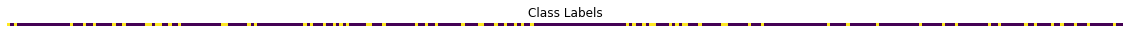

In [3]:
# Set data directory
rootDir = '/blue/camctrp/working/gullettj/ACT/derivatives/SVM/'
anatDir = '/blue/camctrp/working/gullettj/ACT/organized_data/';
funcDir = '/blue/camctrp/working/gullettj/ACT/derivatives/SVM/func/';
sdata = pd.read_csv(os.path.join(rootDir,'subjects_pre-mci_classification.csv')).to_numpy();

# Training Settings
batch_size=32
max_epochs=10
val_interval = 1

# Parameter Settings
im_size = (64,64,64)
grad_clip = 2
step_size = 1
gamma = 7e-1
lr = 1e-5
gr = 16
wd = 1e-6
seed = 42
sp = os.path.join(rootDir,"T1"); # Save Path

# Subjects to Remove
samples_to_exclude = np.array([103744,106986,300142,101644,105903,106078,106817,101395,105554,204085]) # 20ch headcoils
exclude = np.equal(np.isin(sdata[:,0],samples_to_exclude),0);

num_cores = int(os.environ["SLURM_CPUS_PER_TASK"]);

# Two binary labels for Healthy vs pre-MCI
subIdx = np.arange(sdata[exclude,0].shape[0]);
lab = np.array([sdata[:,1]]);
lab = lab[:,exclude]; 

class Diagnosis(Enum):
    normal = 0
    preMCI = 1
    
# Structural MRI
images = np.array([os.path.join(anatDir,''.join(['sub-',str(sdata[s,0])]),'ses-01','anat',''.join(['csub-',str(sdata[s,0]),'_ses-01_T1w.nii'])) for s in range(sdata.shape[0])]);
# images = np.array([os.path.join(rootDir,'anat',''.join(['wc0csub-',str(sdata[s,0]),'_ses-01_T1w.nii'])) for s in range(sdata.shape[0])]);
images = images[exclude]; 

# Functional MRI
fc = np.array([os.path.join(rootDir,'func',''.join(['sub-',str(sdata[s,0]),'_ROIconnectivity.png'])) for s in range(sdata.shape[0])]);
fc = fc[exclude];

# Plot Labels
plt.rcParams['figure.figsize'] = [20, 20]; plt.imshow(lab); 
plt.axis('off'); plt.title('Class Labels');

train case split:  53 : 221
valid case split:  6 : 25
test case split:  7 : 27 

sub-100161 (1/349) T1 Data
(176, 256, 256)


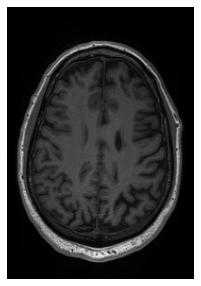

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed)    

# Oversample Minority Class
oversample = RandomOverSampler(sampling_strategy='minority',random_state=seed);
# X, y = oversample.fit_resample(np.asarray([subIdx,subIdx]).T,lab[0,:]);

# Oversampling Minority Class with SVM
sm = SVMSMOTE(sampling_strategy='minority', random_state=seed)
# X, y = sm.fit_resample(np.asarray([subIdx,subIdx]).T,lab[0,:]);

# Undersample Majority Class
# undersample = RandomUnderSampler(sampling_strategy='majority',random_state=seed);
# X, y = undersample.fit_resample(np.asarray([subIdx,subIdx]).T,lab[0,:]);

# Undersample Majority Class by KNN
# X, y = AllKNN().fit_resample(np.asarray([subIdx,subIdx]).T,lab[0,:]);

X, y = np.asarray([subIdx, subIdx]).T, lab[0,:]

nontest_list, test_list, nontest_label, test_label = train_test_split(X[:,0], y,
                                          test_size=0.10,
                                          stratify=y,
                                          random_state=seed)
train_list, valid_list, train_label, valid_label = train_test_split(nontest_list, nontest_label,
                                          test_size=0.10,
                                          stratify=nontest_label,
                                          random_state=seed)

# Oversampling with SVM
# train_list, train_label = sm.fit_resample(np.asarray([train_list,train_list]).T,train_label); train_list = train_list[:,0];
# valid_list, valid_label = sm.fit_resample(np.asarray([valid_list,valid_list]).T,valid_label); valid_list = valid_list[:,0];

# Oversampling 
# train_list, train_label = oversample.fit_resample(np.asarray([train_list,train_list]).T,train_label); train_list = train_list[:,0];
# valid_list, valid_label = oversample.fit_resample(np.asarray([valid_list,valid_list]).T,valid_label); valid_list = valid_list[:,0];


print('train case split: ',sum(train_label),':',len(train_label)-sum(train_label))
print('valid case split: ',sum(valid_label),':',len(valid_label)-sum(valid_label))
print('test case split: ',sum(test_label),':',len(test_label)-sum(test_label),'\n')
del nontest_list, nontest_label; # Save RAM

# Plot Responder Mean
plt.rcParams['figure.figsize'] = [5,5];
np.disp(''.join(['sub-',str(sdata[0,0]),' (1/',str(sdata.shape[0]),') T1 Data']));
nii = nib.load(images[0]); print(nii.shape) # Load Each Electrode
plt.imshow(nii.get_fdata()[:, :, 150].T, cmap="gray", origin="lower"); plt.axis('off'); # Plot

torch.Size([1, 1, 64, 64, 64]) tensor([[[0, 1]]]) torch.Size([1, 1, 2])


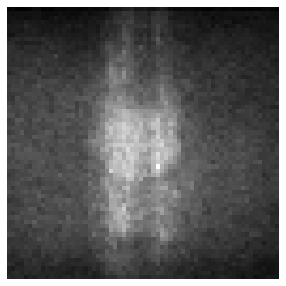

In [5]:
# Represent labels in one-hot format for binary classifier training,
# BCEWithLogitsLoss requires target to have same shape as input
labels = torch.nn.functional.one_hot(torch.as_tensor(lab.T)).long();
train_lab = torch.nn.functional.one_hot(torch.as_tensor(train_label.T)).long(); 
valid_lab = torch.nn.functional.one_hot(torch.as_tensor(valid_label.T)).long();
test_lab = torch.nn.functional.one_hot(torch.as_tensor(test_label.T)).long();

# Define transforms
train_transforms = Compose([
            AddChannel(),
            RandFlip(
                spatial_axis=[0],                   
                prob=0.10,
            ),
            RandFlip(
                spatial_axis=[1],
                prob=0.10,
            ),
            RandFlip(
                spatial_axis=[2],
                prob=0.10,
            ),
            RandRotate90(
                prob=0.10,
                max_k=3,
            ),
            RandShiftIntensity(
                offsets=0.10,
                prob=0.50,
            ),
            Spacing(
                pixdim=(1.0, 1.0, 1.0), # HARDCODED
                mode="bilinear",
                image_only=True,
            ),    
            Orientation(
                axcodes="RAS", 
                image_only=True,
            ),        
            ScaleIntensity(
                minv=0.0,
                maxv=1.0,
            ),
            Resize(im_size),
            EnsureType(data_type='tensor'),
        ]);

val_transforms = Compose([
            AddChannel(),
            Spacing(
                pixdim=(1.0, 1.0, 1.0), 
                mode="bilinear", 
                image_only=True,
            ),
            Orientation(
                axcodes="RAS", 
                image_only=True,
            ),
            ScaleIntensity(
                minv=0.0, 
                maxv=1.0, 
            ),
            Resize(im_size),
            EnsureType(data_type='tensor'),
        ]);

# Define nifti dataset, data loader
check_ds = ImageDataset(image_files=images, labels=labels, transform=train_transforms);
check_loader = DataLoader(check_ds, batch_size=1, num_workers=num_cores, pin_memory=pin_memory);

im, label = monai.utils.misc.first(check_loader); print(im.shape, label, label.shape)
plt.imshow(im[0,0,:,:,60].T, cmap="gray", origin="lower"); plt.axis('off'); del check_ds, check_loader, im, label;

# create a training data loader
train_ds = ImageDataset(image_files=images[train_list], labels=train_lab, transform=train_transforms);
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_cores, pin_memory=pin_memory);

# create a validation data loader
val_ds = ImageDataset(image_files=images[valid_list], labels=valid_lab, transform=val_transforms);
val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=num_cores, pin_memory=pin_memory)

In [6]:
def save_model(n_epoch, save_path, run_id):
        lastmodel = f"{save_path}-{run_id}.pth"
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "best_valid_score": best_valid_score,
                "n_epoch": n_epoch,
            },
            lastmodel,
        )

# Loss Function
loss_fx = nn.binary_cross_entropy_with_logits # BCE

wb.init(project="HACKATHON",
           config={
               "batch_size": batch_size,
               "n_epoch": max_epochs,
               "image_size": im_size,
               "gradient_clip": grad_clip,
               "learning_rate": lr,
               "growth_rate": gr,
               "step_size": step_size,
               "network": "DenseNet264",
               "gamma": gamma,
               "weight_decay": wd,
               "sampling": "",
               "dataset": "ACT",
           }, entity="woodslab")
run_id = wb.run.name;
modelfiles = [None,None] # Pre-allocate for Ensemble

# Train CNN for Structural Data

In [ ]:
# start a typical PyTorch training
epoch_loss_values = [] # Pre-Allocate
epoch_acc_values = [] # Pre-Allocate
sp = os.path.join(rootDir,"T1"); # Save Path

# Create DenseNet264, CrossEntropyLoss and Adam optimizer
model = monai.networks.nets.DenseNet264(spatial_dims=3, in_channels=1, out_channels=2, growth_rate=gr).to(device) # DenseNet
wb.watch(model, log='all')
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd) # Adam

scaler = torch.cuda.amp.GradScaler()
best_valid_score = 99999; # Initialize Loss
lastmodel = None
for epoch in range(max_epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for batch_data in train_loader:
        inputs, label = batch_data[0].to(device), batch_data[1].to(device);
        
        # Evaluate Model
        output = model(inputs);
        loss = loss_fx(output, label.float())
        
        # Update Gradient
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            # Evaluate Model
            output = model(inputs); epoch_prob = torch.sigmoid(output)
            loss = loss_fx(output, label.float())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Accuracy
        acc = (epoch_prob.argmax(dim=1) == label.argmax(dim=1)).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_acc_values.append(acc)
        
        # Loss
        epoch_loss += loss / len(train_loader)
        epoch_loss_values.append(epoch_loss)
#         print(f"train loss: {loss.item():.4f}")
        wb.log({'T1-train_loss': loss, 'T1-train_acc': acc})

    if epoch % val_interval == 0: # Validation Interval
        with eval_mode(model):
            epoch_val_accuracy = 0; epoch_val_loss = 0;
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)

                val_output = model(val_images); val_prob = torch.sigmoid(val_output);
                val_loss = loss_fx(val_output, val_labels.float())

                val_acc = (val_prob.argmax(dim=1) == val_labels.argmax(dim=1)).float().mean()
                epoch_val_accuracy += val_acc / len(val_loader)
                epoch_val_loss += val_loss / len(val_loader)
                wb.log({'T1-val_loss': val_loss, 'T1-val_acc': val_acc})
        print(
            f"Epoch : {epoch+1} - train_loss : {epoch_loss:.4f} - train_acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )
        
        # Save Best Model
        if best_valid_score > epoch_val_loss and epoch != 0:
            print(f"model saved to: {sp}-{run_id}.pth")
            save_model(epoch, sp, run_id)
            best_valid_score = epoch_val_loss
            
    else:    
        print(
            f"Epoch : {epoch+1} - train_loss : {epoch_loss:.4f} - train_acc: {epoch_accuracy:.4f} \n"
        )
modelfiles[0] = f"{sp}-{run_id}.pth"

# Train CNN for Functional Data

In [ ]:
# Define transforms
train_transforms = Compose([
    AsChannelFirst(channel_dim=2),
    Resize((512,512)),
    EnsureType(data_type='tensor')]);
train_ds = ImageDataset(image_files=fc[train_list], labels=train_lab, transform=train_transforms, reader='PILReader');

val_transforms = Compose([
    AsChannelFirst(channel_dim=2),
    Resize((512,512)),
    EnsureType(data_type='tensor')]);
val_ds = ImageDataset(image_files=fc[valid_list], labels=valid_lab, transform=val_transforms, reader='PILReader');
        
# Define nifti dataset, data loader
check_ds = ImageDataset(image_files=fc, labels=labels, transform=train_transforms);
check_loader = DataLoader(check_ds, batch_size=1, num_workers=num_cores, pin_memory=pin_memory);

im, label = monai.utils.misc.first(check_loader); print(im.shape, label, label.shape)
plt.imshow(im[0,0,:,:].T, cmap="gray", origin="lower"); plt.axis('off'); del check_ds, check_loader, im, label;

# create a training data loader
train_ds = ImageDataset(image_files=fc[train_list], labels=train_lab, transform=train_transforms);
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_cores, pin_memory=pin_memory);

# create a validation data loader
val_ds = ImageDataset(image_files=fc[valid_list], labels=valid_lab, transform=val_transforms);
val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=num_cores, pin_memory=pin_memory)

In [ ]:
# start a typical PyTorch training
epoch_loss_values = [] # Pre-Allocate
epoch_acc_values = [] # Pre-Allocate
sp = os.path.join(rootDir,"EPI"); # Save Path

# Create DenseNet264, CrossEntropyLoss and Adam optimizer
model = monai.networks.nets.DenseNet264(spatial_dims=2, in_channels=3, out_channels=2,growth_rate=gr).to(device)
model.summary()
wb.watch(model, log='all')
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd) # Adam

scaler = torch.cuda.amp.GradScaler()
best_valid_score = 99999; # Initialize Loss
lastmodel = None
for epoch in range(max_epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for batch_data in train_loader:
        inputs, label = batch_data[0].to(device), batch_data[1].to(device);
        
        # Evaluate Model
        output = model(inputs);
        loss = loss_fx(output, label.float())
        
        # Update Gradient
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            # Evaluate Model
            output = model(inputs); epoch_prob = torch.sigmoid(output)
            loss = loss_fx(output, label.float())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Accuracy
        acc = (epoch_prob.argmax(dim=1) == label.argmax(dim=1)).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_acc_values.append(acc)
        
        # Loss
        epoch_loss += loss / len(train_loader)
        epoch_loss_values.append(epoch_loss)
#         print(f"train loss: {loss.item():.4f}")
        wb.log({'EPI-train_loss': loss, 'EPI-train_acc': acc})

    if epoch % val_interval == 0: # Validation Interval
        with eval_mode(model):
            epoch_val_accuracy = 0; epoch_val_loss = 0;
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)

                val_output = model(val_images); val_prob = torch.sigmoid(val_output);
                val_loss = loss_fx(val_output, val_labels.float())

                val_acc = (val_prob.argmax(dim=1) == val_labels.argmax(dim=1)).float().mean()
                epoch_val_accuracy += val_acc / len(val_loader)
                epoch_val_loss += val_loss / len(val_loader)
                wb.log({'EPI-val_loss': val_loss, 'EPI-val_acc': val_acc})
        print(
            f"Epoch : {epoch+1} - train_loss : {epoch_loss:.4f} - train_acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )
        
        # Save Best Model
        if best_valid_score > epoch_val_loss and epoch != 0:
            print(f"model saved to: {sp}-{run_id}.pth")
            save_model(epoch, sp, run_id)
            best_valid_score = epoch_val_loss
            
    else:    
        print(
            f"Epoch : {epoch+1} - train_loss : {epoch_loss:.4f} - train_acc: {epoch_accuracy:.4f} \n"
        )
wb.run.log_code(root=os.path.join(os.getcwd(),"CNN_III.ipynb")); 
modelfiles[1] = f"{sp}-{run_id}.pth"

# Test Model

Predict: /blue/camctrp/working/gullettj/ACT/derivatives/SVM/T1-glad-frost-4.pth T1
Predict: /blue/camctrp/working/gullettj/ACT/derivatives/SVM/EPI-glad-frost-4.pth EPI
              precision    recall  f1-score   support

      normal       0.79      1.00      0.89        27
      preMCI       0.00      0.00      0.00         7

    accuracy                           0.79        34
   macro avg       0.40      0.50      0.44        34
weighted avg       0.63      0.79      0.70        34

Ensemble Test AUC: 0.3598 - Test ACC: 0.7941


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


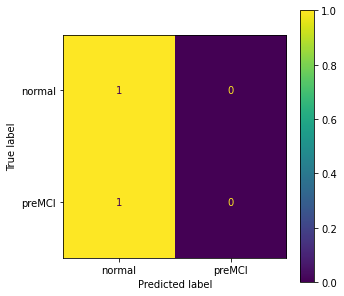

In [26]:
def predict(modelfile, df, mri_type):
    print("Predict:", modelfile, mri_type)  
    # create a testing data loader
    if mri_type == "T1":
        val_transforms = Compose([
            AddChannel(),
            Spacing(
                pixdim=(1.0, 1.0, 1.0), 
                mode="bilinear", 
                image_only=True,
            ),
            Orientation(
                axcodes="RAS", 
                image_only=True,
            ),
            ScaleIntensity(
                minv=0.0, 
                maxv=1.0, 
            ),
            Resize(im_size),
            EnsureType(data_type='tensor'),
        ]);
        test_ds = ImageDataset(image_files=images[df["id"]], labels=test_lab, transform=val_transforms)
        model = monai.networks.nets.DenseNet264(spatial_dims=3, in_channels=1, out_channels=2,growth_rate=gr).to(device)
    elif mri_type == "EPI":
        val_transforms = Compose([
            AsChannelFirst(channel_dim=2),
            Resize((512,512)),
            EnsureType(data_type='tensor')]);
        test_ds = ImageDataset(image_files=fc[df["id"]], labels=test_lab, transform=val_transforms)
        model = monai.networks.nets.DenseNet264(spatial_dims=2, in_channels=3, out_channels=2,growth_rate=gr).to(device)
    test_loader = DataLoader(test_ds, batch_size=batch_size, num_workers=num_cores, pin_memory=pin_memory)
    checkpoint = torch.load(modelfile)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    
    # Pre-allocate
    y_pred = []
    y_prob = []
    
    # Test Loop
    for e, batch in enumerate(test_loader,1):
        data = batch[0].to(device)
        print(f"{e}/{len(test_loader)}", end="\r")
        with torch.no_grad():
            output = model(data);
            tmp_prob = torch.sigmoid(output);
            tmp_pred = tmp_prob.argmax(dim=1);
            if (tmp_prob.size == 1):
                y_pred.append(tmp_pred)
                y_prob.append(tmp_prob)
            else:
                y_pred.extend(tmp_pred.tolist())
                y_prob.extend(tmp_prob.tolist())
    y_prob = [item[1] for item in y_prob] # Convert from One-Hot to Label Encoding
    preddf = pd.DataFrame({"id": df["id"], "prob": y_prob, "pred": y_pred}) 
    preddf = preddf.set_index("id")
    return preddf

rep = 0
mri_types = ["T1","EPI"]
df_pred = {"id": test_list, "label": test_label, "prob": 0, "pred": 0};
for m, mtype in zip(modelfiles,  mri_types):
    pred = predict(m, df_pred, mtype);
    df_pred["prob"] += pred["prob"];
df_pred["prob"] /= len(modelfiles)
df_pred["pred"] = (df_pred["prob"]>=0.5)+0

acc = np.mean(((df_pred["prob"]>=0.5) == df_pred["label"]))
auc = roc_auc_score(df_pred["label"], df_pred["prob"])

# Confusion Matrix                             
print(classification_report(
    df_pred["label"],
    df_pred["pred"],
    target_names=[d.name for d in Diagnosis]))

cm = confusion_matrix(
    df_pred["label"],
    df_pred["pred"],
    normalize='true')

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[d.name for d in Diagnosis])
disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1]);
                            
# Print and Log Overall Test Performance
print(f"Ensemble Test AUC: {auc:.4f} - Test ACC: {acc:.4f}")
wb.log({'test_acc': acc, 'test_auc': auc})
rep += 1

# Occulusion Sensitivity

In [ ]:
# cam = monai.visualize.CAM(nn_module=model_3d, target_layers="class_layers.relu", fc_layers="class_layers.out")
cam = monai.visualize.GradCAMpp(
    nn_module=model, target_layers="class_layers.relu"
)
# cam = monai.visualize.GradCAMpp(nn_module=model_3d, target_layers="class_layers.relu")
print(
    "original feature shape",
    cam.feature_map_size([1, 1] + list(im_size), device),
)
print("upsampled feature shape", [1, 1] + list(im_size))

occ_sens = monai.visualize.OcclusionSensitivity(
    nn_module=model, mask_size=12, n_batch=1, stride=24
)

# For occlusion sensitivity, inference must be run many times. Hence, we can use a
# bounding box to limit it to a 2D plane of interest (z=the_slice) where each of
# the arguments are the min and max for each of the dimensions (in this case CHWD).
the_slice = train_ds[0][0].shape[-1] // 2
occ_sens_b_box = [-1, -1, -1, -1, -1, -1, the_slice, the_slice]; print(occ_sens_b_box)

train_transforms.set_random_state(42)
n_examples = 3
subplot_shape = [3, n_examples]
fig, axes = plt.subplots(*subplot_shape, figsize=(25, 15), facecolor="white")
items = np.random.choice(len(train_ds), size=len(train_ds), replace=False)

example = 0
for item in items:

    data = train_ds[
        item
    ]  # this fetches training data with random augmentations
    image, label = data[0].to(device).unsqueeze(0), data[1][1]
    y_pred = model(image); prob = torch.nn.functional.softmax(y_pred,dim=1);
    pred_label = prob.argmax(dim=1);
    
    # Only display preMCI
    if np.not_equal(label,1):
        continue

    img = image.detach().cpu().numpy()[..., the_slice]

    name = "actual: "
    name += "preMCI" if np.equal(label,1) else "healthy"
    name += "\npred: "
    name += "preMCI" if np.equal(pred_label.cpu().numpy(),1) else "healthy"
    name += f"\npreMCI: {prob[0,1]:.3}"
    name += f"\nhealthy: {prob[0,0]:.3}"

    # run CAM
    cam_result = cam(x=image, class_idx=None)
    cam_result = cam_result[..., the_slice]

    # run occlusion
    occ_result, _ = occ_sens(x=image, b_box=occ_sens_b_box)
    occ_result = occ_result[..., pred_label];

    for row, (im, title) in enumerate(
        zip(
            [img, cam_result, occ_result],
            [name, "CAM", "Occ. Sens."],
        )
    ):
        cmap = "gray" if np.equal(row,0) else "jet"
        ax = axes[row, example]
        if isinstance(im, torch.Tensor):
            im = im.cpu().detach()
        
        im_show = ax.imshow(np.squeeze(im[0][0].T), cmap=cmap, origin='lower')

        ax.set_title(title, fontsize=25)
        ax.axis("off")

    example += 1
    if example == n_examples:
        break
wb.finish()